In [1]:
import numpy as np
import matplotlib.pyplot as plt
from getdist.gaussian_mixtures import GaussianND
from getdist import plots
import sys
sys.path.append('/home/diegop/Desktop/ACT/code_release/')
import act_dr6_analysis.mle as mk
import act_dr6_analysis.binning as bf

#####################################################################
### Configuration of the estimator
#####################################################################
bands          = ['pa4_f220', 'pa5_f090', 'pa5_f150', 'pa6_f090', 'pa6_f150']
exclude_auto   = False
offdiag_blocks = True
ell_diagonal   = False
bp             = bf.BandPowers('baseline')

#####################################################################
### Useful functions
#####################################################################

def avg_rotation(ang, cov):
    iC  = np.linalg.inv(cov)
    w   = np.sum(iC, axis=1)/np.sum(iC)
    m   = np.rad2deg(np.sum(ang*w))
    err = np.rad2deg(np.sqrt(1/np.sum(iC)))
    return m, err 

def format_input(res):   
    rad2deg = 180/np.pi
    Nbands  = 5
    
    vec = np.copy(res['angs/rad'][-1])
    vec[:-Nbands]  *= rad2deg
    vec[Nbands+1:] *= 100
    
    cov = np.copy(res['covariance/rad^2'][-1])
    cov[:Nbands+1, :Nbands+1] *= rad2deg**2
    cov[:Nbands+1, Nbands+1:] *= rad2deg*100
    cov[Nbands+1:, :Nbands+1] *= rad2deg*100
    cov[Nbands+1:, Nbands+1:] *= 100**2
    
    return vec, cov

Working from /home/diegop/Desktop/ACT/code_release/act_dr6_analysis
Creating results directory
Creating priors directory
dr6_lcdm_best_fits/cmb.dat
v1.0/dr6_data.fits


# Compare with ACT DR6 results in the same setting
Fitting a $\psi_i=\alpha_i+\beta$ rotation per frequency band, excluding PA4 f220, and using only $EB$ information within the baseline multipole cut. 

Individual rotations can be combined through a weighted average 
\begin{equation}
\langle\psi_i\rangle = \frac{\sum_{ik}\psi_i(C^{-1})_{ik}}{\sum_{jk}(C^{-1})_{jk}},
\end{equation}
with associated uncertainty $\sigma = \left[\sum_{jk}(C^{-1})_{jk}\right]^{-1/2}$.

Alternatively, the average rotation across bands can be found by fitting a global rotation to all bands, $\Psi_g$.

In [2]:
print('-------------------------------------------------------------------')
print('Reproducing ACT DR6 results from the EB spectra:\n')

mle1_pi = mk.MLE(bands[1:], 'pi', 'EB', bp, 
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle1_pi.load_data()
res1_pi = mle1_pi.solve(save=True)
mk.summary(res1_pi, show_chi2=True, alpha_pa5_discrepancy=True)

avg, std = avg_rotation(res1_pi['angs/rad'][-1], res1_pi['covariance/rad^2'][-1])
print(f'\nThe weighted average gives a ({avg:.3f} \pm {std:.3f})deg rotation')

print('\n-------------------------------------------------------------------')
print('Fitting a global rotation to the EB spectra instead:\n')

mle1_pg = mk.MLE(bands[1:], 'pg', 'EB', bp, 
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle1_pg.load_data()
res1_pg = mle1_pg.solve(save=True)
print(f"Psi_g = ({np.rad2deg(res1_pg['angs/rad'][-1]):.3f} \pm {np.rad2deg(res1_pg['sigma/rad'][-1]):.3f})deg")

-------------------------------------------------------------------
Reproducing ACT DR6 results from the EB spectra:

Solving linear system ...
	 iter 1:
[ 6.450 arcmin, 18.965 arcmin, 7.101 arcmin, 11.071 arcmin ]
	 iter 2:
[ 6.450 arcmin, 18.965 arcmin, 7.101 arcmin, 11.070 arcmin ]
Done!
psi pa5_f090 = (0.108 \pm 0.064)deg
psi pa5_f150 = (0.316 \pm 0.059)deg
psi pa6_f090 = (0.118 \pm 0.074)deg
psi pa6_f150 = (0.185 \pm 0.060)deg
chi square = 677 for 640 dof (PTE = 15.0%)
PA5 f150-f090 = (0.209 \pm 0.086)deg, 2.4sigma discrepancy

The weighted average gives a (0.192 \pm 0.032)deg rotation

-------------------------------------------------------------------
Fitting a global rotation to the EB spectra instead:

Solving linear system ...
	 iter 1:
[ 11.493 arcmi ]
	 iter 2:
[ 11.493 arcmi ]
Done!
Psi_g = (0.192 \pm 0.032)deg


# Baseline results
We now perform a Bayesian analysis using prior information on the instrument model to break the degeneracy between $\beta$ and $\alpha_i$ and simultaneously determine both angles. We do a joint analysis of $C_\ell^{EB}$ and $C_\ell^{TB}$ including PA4 f220.

In [3]:
print('-------------------------------------------------------------------')
print('Fitting alpha_i + beta (EB & TB) with different priors on the optical model:')

print('\n1) Independent alpha_i:\n')
mle2_ind = mk.MLE(bands, 'ab', 'EBxTB', bp, 
                  alpha_prior_file='diag0.09-0.09-0.11_pa456', 
                  exclude_auto_spectra=exclude_auto,
                  include_off_diagonal_obs_blocks=offdiag_blocks,
                  ell_diagonal=ell_diagonal)
mle2_ind.load_data()
res2_ind = mle2_ind.solve(save=True)
mk.summary(res2_ind, show_chi2=True, alpha_pa5_discrepancy=True)

print('\n2) 90% correlation between alpha_i within the same PA:\n')
mle2_pa = mk.MLE(bands, 'ab', 'EBxTB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_PA90_pa456',
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle2_pa.load_data()
res2_pa = mle2_pa.solve(save=True)
mk.summary(res2_pa, show_chi2=True, alpha_pa5_discrepancy=True)

print('\n3) 90% correlation between the alpha_i of array-bands at the same frequency:\n')
mle2_nu = mk.MLE(bands, 'ab', 'EBxTB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_nu90_pa456', 
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle2_nu.load_data()
res2_nu = mle2_nu.solve(save=True)
mk.summary(res2_nu, show_chi2=True, alpha_pa5_discrepancy=True)


-------------------------------------------------------------------
Fitting alpha_i + beta (EB & TB) with different priors on the optical model:

1) Independent alpha_i:

Solving linear system ...
	 iter 1:
[ 12.212 arcmin, 1.396 arcmin, -3.790 arcmin, 4.790 arcmin, -2.295 arcmin, -0.452 arcmin ]
	 iter 2:
[ 12.211 arcmin, 1.393 arcmin, -3.788 arcmin, 4.787 arcmin, -2.292 arcmin, -0.451 arcmin ]
Done!
beta = (0.204 \pm 0.058)deg
alpha pa4_f220 = (0.023 \pm 0.085)deg
alpha pa5_f090 = (-0.063 \pm 0.064)deg
alpha pa5_f150 = (0.080 \pm 0.063)deg
alpha pa6_f090 = (-0.038 \pm 0.072)deg
alpha pa6_f150 = (-0.008 \pm 0.068)deg
chi square = 2031 for 1984 dof (PTE = 22.7%)
PA5 f150-f090 = (0.143 \pm 0.070)deg, 2.0sigma discrepancy

2) 90% correlation between alpha_i within the same PA:

Solving linear system ...
	 iter 1:
[ 12.693 arcmin, 1.365 arcmin, -0.750 arcmin, 1.544 arcmin, -2.125 arcmin, -1.569 arcmin ]
	 iter 2:
[ 12.692 arcmin, 1.363 arcmin, -0.750 arcmin, 1.544 arcmin, -2.123 arcmin, -

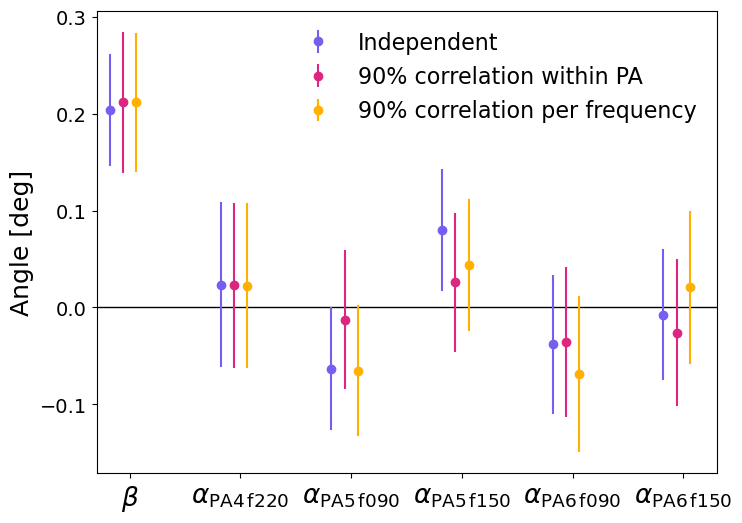

In [4]:
x    = np.arange(0, 6, 1)
step = 0.03

band_labels = [r'$\alpha_\mathrm{PA4\,f220}$',
               r'$\alpha_\mathrm{PA5\,f090}$', r'$\alpha_\mathrm{PA5\,f150}$',
               r'$\alpha_\mathrm{PA6\,f090}$', r'$\alpha_\mathrm{PA6\,f150}$']

plt.figure(figsize=(8, 6))
plt.axhline(y=0, color='k', lw=1, linestyle='-')

plt.errorbar(x-6*step, np.rad2deg(res2_ind['angs/rad'][-1]),
             yerr=np.rad2deg(res2_ind['sigma/rad'][-1]),
             fmt='o', color='#785EF0',
             label='Independent')

plt.errorbar(x-2*step, np.rad2deg(res2_pa['angs/rad'][-1]),
             yerr=np.rad2deg(res2_pa['sigma/rad'][-1]),
             fmt='o', color='#DC267F',
             label='90% correlation within PA')

plt.errorbar(x+2*step, np.rad2deg(res2_nu['angs/rad'][-1]),
             yerr=np.rad2deg(res2_nu['sigma/rad'][-1]),
             fmt='o', color='#FFB000',
             label='90% correlation per frequency')

plt.xticks(ticks=x, labels=[r'$\beta$']+band_labels, 
           fontsize=19, rotation=0)
plt.ylabel('Angle [deg]', fontsize=18)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=1, frameon=False)
plt.xlim((x[0]-10*step, x[-1]+10*step))
plt.show()


# Cross-check using only $TB$ information
We perform the same Bayesian analysis using prior information on the instrument model to break the $\alpha+\beta$ degeneracy, but using only $C_\ell^{TB}$ this time.

In [5]:
print('-------------------------------------------------------------------')
print('Fitting alpha_i + beta (TB only) with different priors on the optical model:')

print('\n1) Independent alpha_i:\n')
mle3_ind = mk.MLE(bands, 'ab', 'TB', bp, 
                  alpha_prior_file='diag0.09-0.09-0.11_pa456', 
                  exclude_auto_spectra=exclude_auto,
                  include_off_diagonal_obs_blocks=offdiag_blocks,
                  ell_diagonal=ell_diagonal)
mle3_ind.load_data()
res3_ind = mle3_ind.solve(save=True)
mk.summary(res3_ind, show_chi2=True, alpha_pa5_discrepancy=True)

print('\n2) 90% correlation between alpha_i within the same PA:\n')
mle3_pa = mk.MLE(bands, 'ab', 'TB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_PA90_pa456',
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle3_pa.load_data()
res3_pa = mle3_pa.solve(save=True)
mk.summary(res3_pa, show_chi2=True, alpha_pa5_discrepancy=True)
    
print('\n3) 90% correlation between the alpha_i of array-bands at the same frequency:\n')
mle3_nu = mk.MLE(bands, 'ab', 'TB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_nu90_pa456',
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle3_nu.load_data()
res3_nu = mle3_nu.solve(save=True)
mk.summary(res3_nu, show_chi2=True, alpha_pa5_discrepancy=True)

-------------------------------------------------------------------
Fitting alpha_i + beta (TB only) with different priors on the optical model:

1) Independent alpha_i:

Solving linear system ...
	 iter 1:
[ 15.037 arcmin, 0.049 arcmin, -0.703 arcmin, 1.705 arcmin, -1.836 arcmin, 1.008 arcmin ]
	 iter 2:
[ 15.037 arcmin, 0.049 arcmin, -0.704 arcmin, 1.706 arcmin, -1.837 arcmin, 1.008 arcmin ]
Done!
beta = (0.251 \pm 0.124)deg
alpha pa4_f220 = (0.001 \pm 0.089)deg
alpha pa5_f090 = (-0.012 \pm 0.086)deg
alpha pa5_f150 = (0.028 \pm 0.085)deg
alpha pa6_f090 = (-0.031 \pm 0.103)deg
alpha pa6_f150 = (0.017 \pm 0.101)deg
chi square = 1010 for 989 dof (PTE = 31.5%)
PA5 f150-f090 = (0.040 \pm 0.118)deg, 0.3sigma discrepancy

2) 90% correlation between alpha_i within the same PA:

Solving linear system ...
	 iter 1:
[ 15.222 arcmin, 0.048 arcmin, 0.707 arcmin, 0.981 arcmin, -0.797 arcmin, -0.455 arcmin ]
	 iter 2:
[ 15.223 arcmin, 0.048 arcmin, 0.707 arcmin, 0.981 arcmin, -0.797 arcmin, -0.455 

# Marginalizing over residual $I\rightarrow P$ leakage
We extend our estimator to simultaneously fit for birefringence, miscalibration angles, and a residual $I\rightarrow P$ leakage per band of amplitude $\gamma_i$. We do a joint analysis of $C_\ell^{EB}$ and $C_\ell^{TB}$, including PA4 f220.

In [6]:
print('-------------------------------------------------------------------')
print('Fitting alpha_i + beta + gamma_i (EB & TB) with different priors on the optical model:')

print('\n1) Independent alpha_i:\n')
mle4_ind = mk.MLE(bands, 'abg', 'EBxTB', bp, 
                  alpha_prior_file='diag0.09-0.09-0.11_pa456', 
                  exclude_auto_spectra=exclude_auto,
                  include_off_diagonal_obs_blocks=offdiag_blocks,
                  ell_diagonal=ell_diagonal)
mle4_ind.load_data()
res4_ind = mle4_ind.solve(save=True)
mk.summary(res4_ind, show_chi2=True, alpha_pa5_discrepancy=True)

print('\n2) 90% correlation between alpha_i within the same PA:\n')
mle4_pa = mk.MLE(bands, 'abg', 'EBxTB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_PA90_pa456',
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle4_pa.load_data()
res4_pa = mle4_pa.solve(save=True)
mk.summary(res4_pa, show_chi2=True, alpha_pa5_discrepancy=True)

print('\n3) 90% correlation between the alpha_i of array-bands at the same frequency:\n')
mle4_nu = mk.MLE(bands, 'abg', 'EBxTB', bp, 
                 alpha_prior_file='diag0.09-0.09-0.11_nu90_pa456', 
                 exclude_auto_spectra=exclude_auto,
                 include_off_diagonal_obs_blocks=offdiag_blocks,
                 ell_diagonal=ell_diagonal)
mle4_nu.load_data()
res4_nu = mle4_nu.solve(save=True)
mk.summary(res4_nu, show_chi2=True, alpha_pa5_discrepancy=True)

-------------------------------------------------------------------
Fitting alpha_i + beta + gamma_i (EB & TB) with different priors on the optical model:

1) Independent alpha_i:

Solving linear system ...
	 iter 1:
[ 12.458 arcmin, 1.511 arcmin, -3.797 arcmin, 4.529 arcmin, -1.392 arcmin, -1.102 arcmin, 0.050%, 0.014%, -0.011%, 0.081%, -0.054% ]
	 iter 2:
[ 12.457 arcmin, 1.508 arcmin, -3.794 arcmin, 4.527 arcmin, -1.389 arcmin, -1.101 arcmin, 0.050%, 0.014%, -0.011%, 0.081%, -0.054% ]
Done!
beta = (0.208 \pm 0.059)deg
alpha pa4_f220 = (0.025 \pm 0.085)deg
alpha pa5_f090 = (-0.063 \pm 0.064)deg
alpha pa5_f150 = (0.075 \pm 0.063)deg
alpha pa6_f090 = (-0.023 \pm 0.072)deg
alpha pa6_f150 = (-0.018 \pm 0.068)deg
gamma pa4_f220 = (0.050 \pm 0.152)%
gamma pa5_f090 = (0.014 \pm 0.046)%
gamma pa5_f150 = (-0.011 \pm 0.042)%
gamma pa6_f090 = (0.081 \pm 0.050)%
gamma pa6_f150 = (-0.054 \pm 0.046)%
chi square = 2027 for 1979 dof (PTE = 22.1%)
PA5 f150-f090 = (0.139 \pm 0.070)deg, 2.0sigma discre

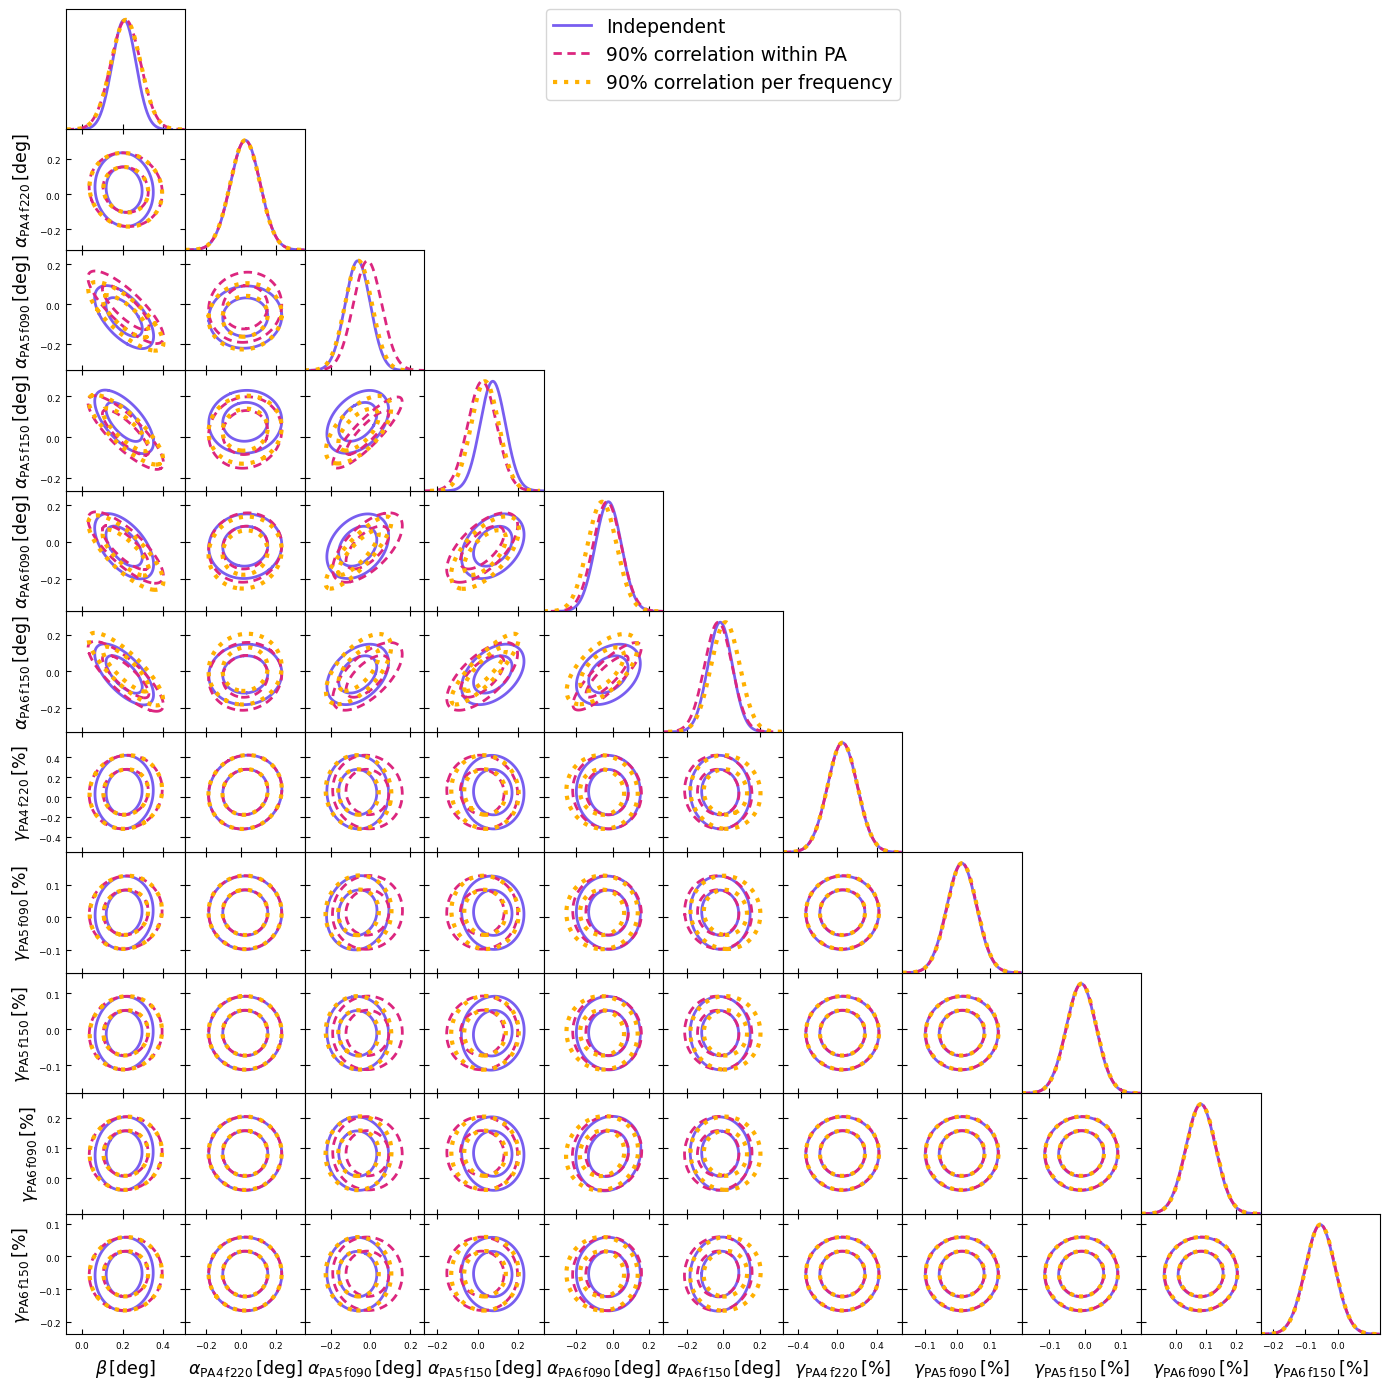

In [7]:
labels = [r'\beta\,[{\rm deg}]', 
          r'\alpha_{{\rm PA4\,f220}}\,[{\rm deg}]',
          r'\alpha_{{\rm PA5\,f090}}\,[{\rm deg}]',
          r'\alpha_{{\rm PA5\,f150}}\,[{\rm deg}]', 
          r'\alpha_{{\rm PA6\,f090}}\,[{\rm deg}]', 
          r'\alpha_{{\rm PA6\,f150}}\,[{\rm deg}]',
          r'\gamma_{{\rm PA4\,f220}}\,[\%]',
          r'\gamma_{{\rm PA5\,f090}}\,[\%]',
          r'\gamma_{{\rm PA5\,f150}}\,[\%]', 
          r'\gamma_{{\rm PA6\,f090}}\,[\%]', 
          r'\gamma_{{\rm PA6\,f150}}\,[\%]']
 
alphas = ['alpha_pa4_f220', 'alpha_pa5_f090', 'alpha_pa5_f150', 'alpha_pa6_f090', 'alpha_pa6_f150']
gammas = ['gamma_pa4_f220', 'gamma_pa5_f090', 'gamma_pa5_f150', 'gamma_pa6_f090', 'gamma_pa6_f150']

v_ind, c_ind = format_input(res4_ind)
gauss_ind = GaussianND(v_ind, c_ind, names=['beta']+alphas+gammas, labels=labels)

v_pa, c_pa = format_input(res4_pa)
gauss_pa = GaussianND(v_pa, c_pa, names=['beta']+alphas+gammas, labels=labels)

v_nu, c_nu = format_input(res4_nu)
gauss_nu = GaussianND(v_nu, c_nu, names=['beta']+alphas+gammas, labels=labels)

g = plots.get_subplot_plotter(width_inch=14) 
g.settings.legend_fontsize=18
g.settings.axes_labelsize=17
g.triangle_plot([gauss_ind, gauss_pa, gauss_nu],
                ['beta']+alphas+gammas,
                filled=False,
                legend_labels=['Independent',
                               '90% correlation within PA',
                               '90% correlation per frequency'],
                contour_colors=['#785EF0', '#DC267F','#FFB000'],
                contour_lws=[2, 2, 3], 
                contour_ls=['-', '--', ':'])
plt.show()